[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/01_data_handling/03_pytorch_data_augmentation.ipynb)

# 🛰️ 03: Scalable Augmentation & High-Throughput Pipelines (PyTorch)
### Geospatial Land Classification Study (PyTorch Phase)
(*This is the 3rd module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module evaluates the **PyTorch Data Ecosystem** for high-performance geospatial image classification. Unlike monolithic data loaders, PyTorch utilizes a decoupled architecture that separates the data source definition from the multi-process execution engine.

**Key Technical Focus:**
* **Compositional Augmentation:** Utilizing `torchvision.transforms` for non-destructive, on-the-fly tensor manipulations.
* **Separation of Concerns:** Evaluating the relationship between `torch.utils.data.Dataset` (representation) and `DataLoader` (iteration).
* **Parallelization:** Implementing multi-worker data loading to mitigate the Python Global Interpreter Lock (GIL) during heavy augmentation.

## Introduction

This module implements the **PyTorch** utilities for the construction of automated data pipelines. PyTorch's modular approach separates *data representation* from *data iteration*:

### Implementation: Custom Map-Style `Dataset` Class
A dataset class was built from scratch by inheriting from `torch.utils.data.Dataset`. This provides control and a deep understanding of the data pipeline.

### Implementation: Built-in `ImageFolder` Utility
By using the convenient `torchvision.datasets.ImageFolder` class,  data is handled automatically from a standard directory structure.

### Implementation The `DataLoader`
The datasets have been wrapped in a `DataLoader`, PyTorch's engine for efficient batching, shuffling, and parallelized data loading.

The comparison of these methods allows us to understand why this modular design is so powerful


## Table of contents


<div>
<font size = 3>    

1. [Import libraries and packages](#Import-libraries-and-packages)
1.  [Implementation: Custom Map-Style `Datasets`](#Implementation:-Custom-Map-Style-Datasets)
2.  [Optimization: Standardized ImageFolder Ingestion](#Optimization:-Standardized-ImageFolder-Ingestion)
3.  [The `DataLoader` - Bringing it all together](#The-DataLoader---Bringing-it-all-together)
4.  [Comparison and analysis](#Comparison-and-analysis)

</font>
</div>


## Import libraries and packages

In [ ]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 torch==2.7.1 torchvision==0.22 requests\
         Pillow --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

## Dataset acquisition and extraction
The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.


In [3]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [4]:
# Define directories
base_dir = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

## Implementation: Custom Map-Style Datasets

In PyTorch, 
- A `Dataset` object is an iterable (gives one sample at a time).

- A `DataLoader` is an iterator that returns batches (adds a batch dimension: `[B, C, H, W]`).

- To create a custom dataset, is defined a class that inherits from `torch.utils.data.Dataset` and implements three essential methods:
- `__init__(self)`: This method is run once when the dataset is instantiated. It performs the initial setup, such as loading file paths and labels.
- `__len__(self)`: This returns the total number of samples in the dataset.
- `__getitem__(self, idx)`: This method is responsible for loading and returning a *single* sample from the dataset at the given index `idx`. This is the core of sequential loading; it fetches one data point from storage "just-in-time".


In [5]:
#--- Custom Dataset Class ---
# This class allows to create a PyTorch Dataset object that can be used with DataLoader for efficient batching and shuffling.
# It reads images from the specific directories, assigns labels based on the directory (0 for non-agri, 1 for agri), and applies any specified transformation.
# The __getitem__ method is responsible for loading an image, applying transgormations, and returning the image along with its label when the dataset is indexed.
# The __len__ method returns the total number of samples in the dataset, which is eesential for PyTorch to know how many batches to create during training.
class CustomBinaryClassDataset(Dataset):
    '''
    A custom dataset for our agricultural land classification task.
    It loads images from two directories (agricultural and non-agricultural), assigns labels, and applies transformations if provided.
    Args:
        non_agri_dir (string): Directory with all the non-agricultural images.
        agri_dir (string): Directory with all the agricultural images.
        transform (callable, optional): Optional transform to be applied on a sample.
    Returns:
        image (Tensor): Transformed image tensor.
        label (int): Corresponding label (0 for non-agri, 1 for agri).
    '''
    def __init__(self, non_agri_dir, agri_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load non-agri paths and assign label 0
        for fname in os.listdir(non_agri_dir):
            self.image_paths.append(os.path.join(non_agri_dir, fname))
            self.labels.append(0)
            
        # Load agri paths and assign label 1
        for fname in os.listdir(agri_dir):
            self.image_paths.append(os.path.join(agri_dir, fname))
            self.labels.append(1)

        temp = list(zip(self.image_paths, self.labels))
        np.random.shuffle(temp)
        self.image_paths, self.labels = zip(*temp)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB") # Ensure image is in RGB format
        
        label = self.labels[idx]
        
        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
            
        return image, label

Custom Dataset classes provide maximum flexibility for non-standard geospatial metadata handling, allowing for complex per-sample logic.

### Define transformations

- `torchvision.transforms` provides a suite of common image transformations. These are used for preprocessing (such as `resizing` and `converting to a tensor`) and data augmentation (such as `random flips` and `rotations`).
- `transforms.Compose` chains these operations together into a single, callable pipeline. Data augmentation is a crucial regularization technique that helps prevent overfitting by showing the model slightly different versions of the same image at each epoch.
- Transforms like `RandomFlip` and `Rotation` work on PIL images and must be applied before `ToTensor()`, which converts images to tensors.
- `Normalize()` scales tensor values (e.g., from `[0, 1]` to `[-1, 1]`) using `(x - mean) / std`  or can be based on the model being fine tuned.


**Transformation pipeline parameters:**

  1. image size = $64 \times 64$ pixels
  2. RandomHorizontalFlip probability 0.5
  3. RandomVerticalFlip probability 0.2
  4. RandomRotation of 45 degrees

Then, transform it to tensor and normalize it to [-1, 1]


In [6]:
# Definition of custom transform pipeline
custom_transform = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.RandomHorizontalFlip(0.5),
                                     transforms.RandomVerticalFlip(0.2),
                                     transforms.RandomRotation(45),
                                     transforms.ToTensor(), # Converts PIL Image to a tensor and scales values to [0, 1]
                                     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]) # Normalize to [-1, 1]
])

## Optimization: Standardized ImageFolder Ingestion

For datasets that follow a standard `root/class_name/xxx.ext` directory structure, PyTorch provides `torchvision.datasets.ImageFolder`. This is a specialized `Dataset` class that does all the work of finding image paths and inferring class labels. It's the most convenient way to load image datasets organized in folders, where each subfolder represents a different class.

**ImageFolder** acts as a quick bridge between raw image files and PyTorch models. By pointing the `root` argument at the top-level dataset folder, the class automatically walks through every subfolder, using each subfolder’s name as a label. A `transform pipeline` can be attached with common choices including `transforms.Resize`, `transforms.CenterCrop`, `transforms.ToTensor`, and `transforms.Normalize` to pre-process every image on the fly. Calling `len(dataset)` reveals total images, while indexing `dataset[i]` returns an `(image, label)` pair. It can then ne combined with `DataLoader` to batch, shuffle, and parallel-load data effortlessly.

**ImageFolder** works on the `dataset folder` structured as represented below:

    dataset/
    ├── class1/
    │   ├── image1.jpg
    │   └── image2.jpg
    └── class2/
        ├── image3.jpg
        └── image4.jpg
    

A `dataset object` is created as follows: 

```
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(
    root='path/to/dataset',
    transform=transform
)
```

This `dataset object` can then be used to create a `dataloader` like this:
```
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    # Training code here
    .
    .
    ...

```
This `dataloader` can then be used for creating batches of images for training / testing of the model.

**`ImageFolder`** automatically assigns numerical labels to classes based on folder names alphabetically. Access class names via `dataset.classes` and class-to-index mapping via `dataset.class_to_idx`


### Get the dataset **imagefolder_dataset** using `datasets.Imagefolder` method and applying **custom_transform**


In [7]:
# Load dataset
imagefolder_dataset = datasets.ImageFolder(
    root=base_dir,
    transform=custom_transform
)

The ImageFolder utility provides a high-performance baseline for datasets following a categorical directory structure, optimized for rapid prototyping.

### Print the name and the class index from the **imagefolder_dataset**


In [8]:
# Print class names and their mapping to indexes
print(f'Class names: {imagefolder_dataset.classes}')
print(f'Class indexes: {imagefolder_dataset.class_to_idx}')

Class names: ['class_0_non_agri', 'class_1_agri']
Class indexes: {'class_0_non_agri': 0, 'class_1_agri': 1}


## The `DataLoader` - Bringing it all together

The `DataLoader` is an iterator that returns batches, based on the `batch_size`. It wraps a `Dataset` object and provides an iterable to access the data. Its key responsibilities are:
- **Batching:** This involves grouping individual samples into mini-batches.
- **Shuffling:** This involves randomly shuffling the data every epoch to prevent the model from learning the order of samples. The data loading process is parallelized, preventing the CPU from becoming a bottleneck for the GPU.

The `DataLoader` can be used with **both** the `CustomBinaryClassDataset` and the `ImageFolder` dataset.

Linear and convolution layers in a neural network can work **with or without** the batch dimension 
- e.g., with shapes `[C, H, W]` or  `[B, C, H, W]`, where:
    - `B`: `batch_size`
    - `C`: `number of channels`
    - `H`: `image height`
    - `W`: `image width`

In [ ]:
BATCH_SIZE = 8 #  the number of images in a batch (batch size)

# Technical Note: num_workers is set to 0 on Windows (nt) to avoid 
# recursive multiprocessing overhead in Jupyter environments.
num_workers = 0 if os.name == 'nt' else os.cpu_count()

# --- Using the Custom Dataset ---
custom_dataset = CustomBinaryClassDataset(dir_non_agri, dir_agri, transform=custom_transform)
custom_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

# --- Using the ImageFolder Dataset ---
imagefolder_loader = DataLoader(imagefolder_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

print("DataLoaders created successfully!")

DataLoaders created successfully!


The num_workers parameter in the DataLoader is set dynamically based on the available hardware (os.cpu_count()), ensuring maximum data throughput by bypassing the Python GIL through multi-process execution.

### Verification of a batch of images and labels from the Custom Dataset

The inspection of a batch from the `DataLoader` is performed by using  `iter()` and `next()` to pull a single batch. This is exactly what a training loop does under the hood. Visualizing the images and their labels confirms that the entire pipeline (from path loading and transformation to batching) is working correctly.


In [10]:
# Get one batch from the Custom loader
images_custom, labels_custom = next(iter(custom_loader))

print(f"Images batch shape (Custom loader): {images_custom.shape}") 
print(f"Labels batch shape (Custom loader): {labels_custom.shape}")


Images batch shape (Custom loader): torch.Size([8, 3, 64, 64])
Labels batch shape (Custom loader): torch.Size([8])


### Verification of a batch of images and labels from the `imagefolder_loader` 


In [11]:
# Get one batch from the imagefolder_loader
images_inbuilt, labels_inbuilt = next(iter(imagefolder_loader))

print(f"Images batch shape (ImageFolder loader): {images_inbuilt.shape}") 
print(f"Labels batch shape (ImageFolder loader): {labels_inbuilt.shape}")


Images batch shape (ImageFolder loader): torch.Size([8, 3, 64, 64])
Labels batch shape (ImageFolder loader): torch.Size([8])


Function to display an image from the batch. 


In [12]:
# Define a helper function to visualize images.
def imshow(img):
    """
    Helper function to un-normalize and display an image.

    Args:
        img (Tensor): A batch of images in tensor format, normalize to [-1, 1]

    Returns:
        Displays the image using matplotlib
    """
    img = img / 2 + 0.5  # Un-normalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from C,H,W to H,W,C

### Display the images in the PyTorch in-built loader batch


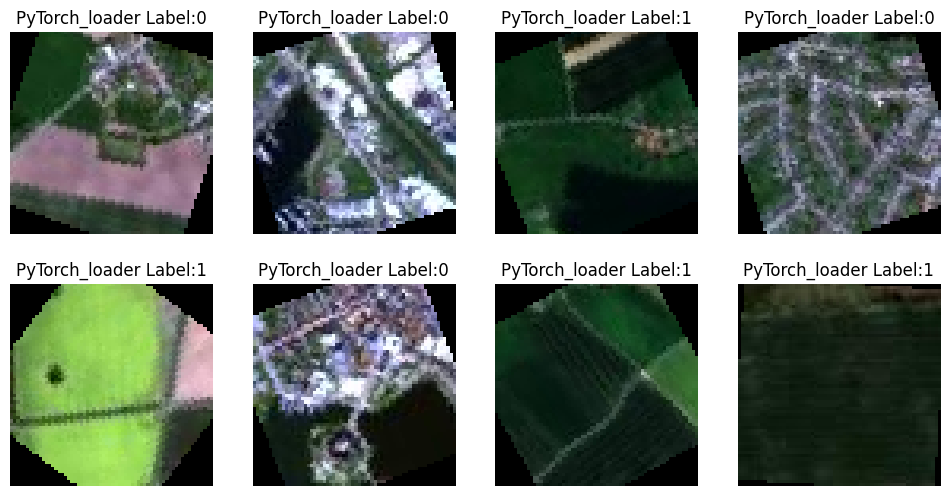

In [13]:
# Visualize a batch of images from the imagefolder_loader
plt.figure(figsize = (12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_inbuilt[i])
    plt.title(f"PyTorch_loader Label:{labels_inbuilt[i].item()}")
    plt.axis("off")

### Display the images in the Custom loader batch
Display the images stored in `images_custom` generated using `custom_loader`. 

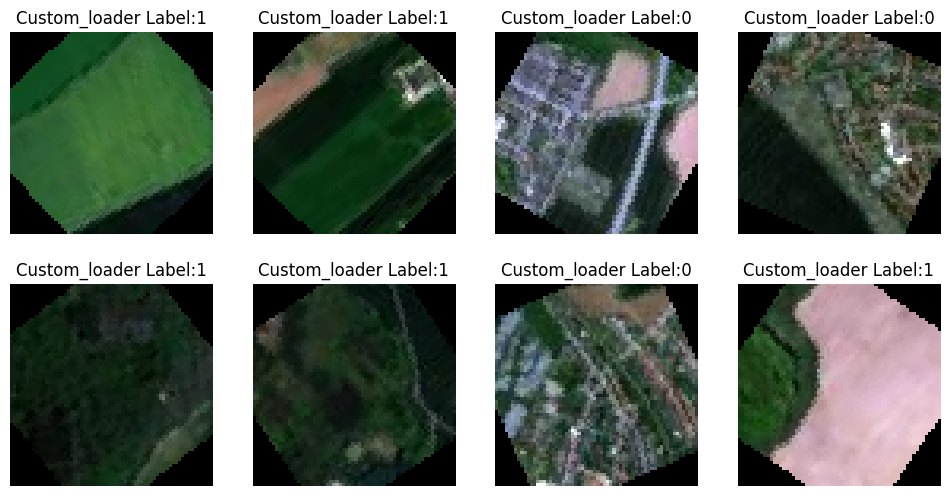

In [14]:
# Displaying a batch of images from custom_loader
plt.figure(figsize = (12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_custom[i])
    plt.title(f"Custom_loader Label:{labels_custom[i].item()}")
    plt.axis("off")


## Comparison and analysis

In PyTorch, both methods lead to a `DataLoader`. The key difference lies in how the underlying `Dataset` is created.


| Feature                  | Custom `Dataset` Class                                       | `ImageFolder` Utility    |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. It requires writing a custom class with three specific methods. | High. It requires only a single, intuitive class instantiation. |
| **Code complexity**      | High. You manually manage file paths, labels, and the loading logic inside `__getitem__`. | Low. The class handles all path and label discovery automatically.          |
| **Flexibility**          | Very high. It is essential for non-standard directory structures, loading labels from a CSV/JSON, or complex loading logic (for example, from a database). | Moderate. It strictly requires the `root/class/image.ext` directory structure. |
| **Performance**          | Potentially high. Performance depends on the efficiency of the `__getitem__` method. When wrapped in a `DataLoader` with `num_workers`, it can be highly performant. | High. `ImageFolder` is optimized and, when wrapped in a `DataLoader`, provides excellent performance out-of-the-box. |
| **Recommended for**      | It is recommended for complex, non-standard datasets or when you need fine-grained control over every aspect of data loading. | It is recommended for almost all standard image classification tasks.        |


---
**Notebook 03 Conclusion:** This module successfully established the PyTorch data pipeline baseline. By decoupling data representation via `Dataset` and iteration via `DataLoader`, we created a modular framework capable of multi-threaded data ingestion.

The implementation of `torchvision.transforms` ensures that spatial variances in satellite imagery are addressed through on-the-fly augmentation, preventing overfitting. This robust pipeline completes the data engineering phase of our research and will serve as the primary ingestion engine for the **PyTorch Vision Transformer (Notebook 08)** and the final **Hybrid Study (Notebook 09)**.